# U-Net CNN for LULC of Aerial Data
###### *Connor Crowe*

**Objective**: This notebook trains a **U-Net Convolutional Neural Network (CNN)** to classify land use and land cover (LULC) from aerial imagery. The goal is to generate a segmentation mask that accurately identifies different land cover types in Toronto, Canada.

🔗 View previous models: [Repository](https://github.com/connorcrowe/to-lulc-aiml)

**Dataset**: 
- **Aerial Imagery**: training and prediction aerial clipped from [Toronto Aerial Imagery GIS Map Server (2019)](https://gis.toronto.ca/arcgis/rest/services/basemap/cot_ortho/MapServer)
    - Training image size: 1024px (initially 512px)
- **Labelled Rasters**: rasters manually digitized from the aerial imagery above
    - Classes: road, building, vegetation, pavement
  
**Workflow**:
- Data Preprocessing - Image patching, data augmentation
- Model: Compiling, fiting and measuring the U-Net 
- Prediction: Generates segmentation mask on new data

**About U-Net**:

A U-Net model is good for semantic segmentaion (e.g. identifying buildings from roads), but a more sophisticated model is likely needed for instance segmentation (e.g. identifying distinct building footprints). A U-net has a few structural components:
- **Encoder**: progessively downsamples the input while capturing context with filters and pooling
- **Decoder**: upsamples the features and combines then with higher resolution features from the encoder
- **Skip Connections**: help to preserve precise spatial information and resolution of features during downsampling 

In [7]:
# IMPORTS AND RANDOM SEEDS
import os
import warnings
import rasterio
import rasterio.plot
from rasterio.mask import mask
from rasterio.plot import reshape_as_image
import matplotlib.pyplot as plt

import geopandas as gpd
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

from patchify import unpatchify
from patchify import patchify

RNG_SEED = 42
np.random.seed(RNG_SEED)
tf.random.set_seed(RNG_SEED)

### Configuration
Variables that affect execution parameters and other optional settings.

In [8]:
# Train or Load model
# Using an existing model will skip the training step, saving time
train_or_load_model = "train"

In [9]:
# Patch settings
patch_size = 128      # Size of each training patch
patch_step = 32       # Overlap step between patches

# Training Settings
percent_augment = 0.5   # Amount of the training data set to randomly augment (brightness, orientation)
epochs = 50          # Epochs of training for the CNN (early stopping is enabled)

# Extra output and Memory Settings
optional_visuals = 1  # Whether or not to show input training data
optional_shapes  = 1  # Whether or not to include optional print statements that check shape data

In [10]:
# Resource Management Setings
extra_garbage_collection = 1   # Whether or not to clean up extra memory during execution. Needed for high resolution images or on low memory hardware
tf.config.threading.set_intra_op_parallelism_threads(6) # Maximum parallel CPU threads to allocate
tf.config.threading.set_inter_op_parallelism_threads(6)

## Data Import
Import matching aerial images and labelled rasters from directories below. Also import the larger image to be predicted once the model is trained.

In [11]:
path_aerials = "input/aerial/512/"                   # Folder with training aerial images
path_labels = "input/label/512/"                     # Folder with matching training labels
path_image_to_predict = "input/full/512/aerial.tif"   # Path to image to make prediction on

model_path = "input/models/unet_model_512pd_4layer_batch_drop_5deepkernel.keras"             # Path to existing model if not re-training

In [12]:
# IMPORT IMAGE, AERIALS AND LABELS FROM FOLDER 
aerials = []
labels = []

# Load aerial image to predict
with rasterio.open(path_image_to_predict) as src:
    full_image = src.read()[0:3] # Remove 4th band (alpha)
    metadata = src.meta.copy()
    

# Load in aerial images
for file in os.listdir(path_aerials):
    with rasterio.open(path_aerials + file) as src:
        image = src.read()[0:3]           # Remove 4th (alpha) band
        #image.astype(np.float32) / 255.0  # Normalize to 0-1 range
        aerials.append(image) 

# Load in raster classes
for file in os.listdir(path_labels):
    with rasterio.open(path_labels + file) as src:
        labels.append(src.read()[0])

print(f"Loaded prediction image with shape {full_image.shape}")
print(f"Loaded {len(aerials)} aerials with shape {aerials[0].shape}")
print(f"Loaded {len(labels)} labels with shape {labels[0].shape}")

Loaded prediction image with shape (3, 2892, 4336)
Loaded 8 aerials with shape (3, 512, 512)
Loaded 8 labels with shape (512, 512)


#### ***Optional:*** *Visualize imported data*

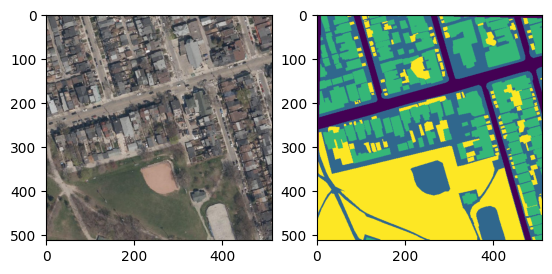

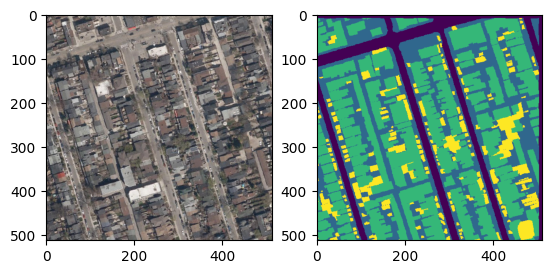

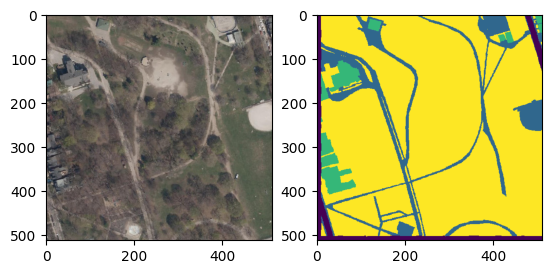

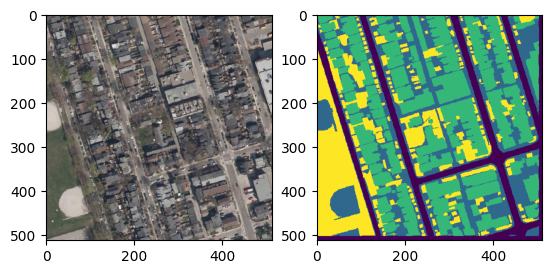

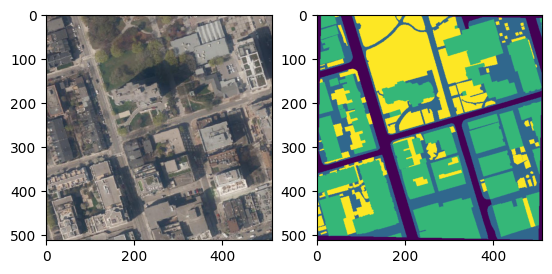

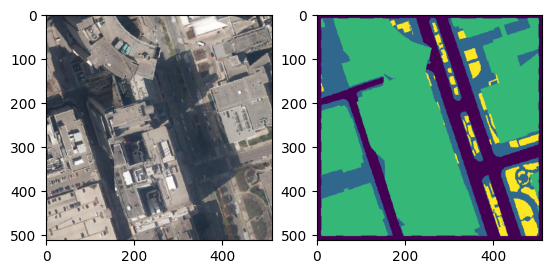

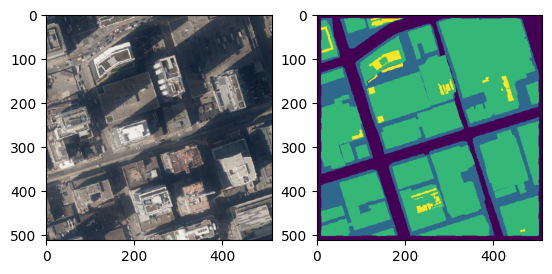

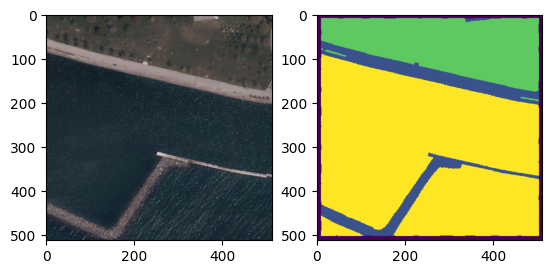

In [13]:
if optional_visuals:
    # Visualize input aerials and labels
    for i in range(len(aerials)):
        fig, ax = plt.subplots(1,2)
        ax[0].imshow(reshape_as_image(aerials[i]))
        ax[1].imshow(labels[i])

## Data Preparation
Before training, the data is prepared by:
- **One Hot Encoding**: Convert numerical class to categorical columns
- **Train test split**: Split off parts of input images for training before patching (to prevent data leakage in overlap)
- **Patching**: Splitting the input (1024px) images into smaller patches
- **Overlapping Patches**: An overlap between patches prevents segmentation artifacts at patch boundaries
- **Data Augmentation**: Random rotations, flips, brightess, saturation, hue and noise to improve generalization.

### Convert class labels to categorical (one-hot encoding)

In [14]:
# ONE HOT ENCODE
num_classes = len(np.unique(labels))
labels_encoded = to_categorical(labels, num_classes=num_classes)

if optional_shapes: print(labels_encoded.shape)

(8, 512, 512, 5)


### Train-Test split
Testing data is split off from the training data before overlapping patches are created, so that there is no overlap between the border regions of the training and test sets. This would cause a data leakage issue where some regions appear in both sets. 

In [15]:
# TRAIN TEST SPLIT
aerial_train, aerial_test, label_train, label_test = [], [], [], []
split_x = int(aerials[0].shape[1] * 0.75) 

# Split end range of images off for testing
for i in range(len(aerials)):
    aerial_train.append(aerials[i][:, :, :split_x])
    aerial_test.append(aerials[i][:, :, split_x:])

    label_train.append(labels_encoded[i][:, :split_x, :])
    label_test.append(labels_encoded[i][:, split_x:, :])

if optional_shapes:
    print(f"aerial_train: {len(aerial_train), aerial_train[0].shape}")
    print(f"aerial_test: {len(aerial_test), aerial_test[0].shape}")
    print(f"label_train: {len(label_train), label_train[0].shape}")
    print(f"label_test: {len(label_test), label_test[0].shape}")

aerial_train: (8, (3, 512, 384))
aerial_test: (8, (3, 512, 128))
label_train: (8, (512, 384, 5))
label_test: (8, (512, 128, 5))


### Create Image Patches
The input images must be split into smaller samples before training the model, achieved using Patchify. By setting a patch step smaller than the patch size, the resulting patches overlap. This can help to expand the training set and give the model better spatial representation, especially on border regions between patches.

- Through experimentation, the best ratio for this purpose and data set is `patch_step = patch_size / 4`

In [16]:
# CREATE OVERLAPPING PATCHES
patches_aerial_train, patches_aerial_test = [], []
patches_label_train, patches_label_test = [], []

# Patchify each train and test region
for i in range(len(aerial_train)):
    patches_aerial_train.append(patchify(aerial_train[i], (3, patch_size, patch_size), step=patch_step)[0])
    patches_aerial_test.append(patchify(aerial_test[i], (3, patch_size, patch_size), step=patch_step)[0])
    
    patches_label_train.append(patchify(label_train[i], (patch_size, patch_size, num_classes), step=patch_step))
    patches_label_test.append(patchify(label_test[i], (patch_size, patch_size, num_classes), step=patch_step))

# Convert lists to np array so that they can be reshaped and transposed
patches_aerial_train = np.array(patches_aerial_train, dtype=np.float32)
patches_aerial_test = np.array(patches_aerial_test)
patches_label_train = np.array(patches_label_train)
patches_label_test = np.array(patches_label_test)

# Reshape and transpose into one list of patches
patches_aerial_train = patches_aerial_train.reshape(-1, 3, patch_size, patch_size)
patches_aerial_train = np.transpose(patches_aerial_train, (0, 2, 3, 1))

patches_aerial_test = patches_aerial_test.reshape(-1, 3, patch_size, patch_size)
patches_aerial_test = np.transpose(patches_aerial_test, (0, 2, 3, 1))

patches_label_train = patches_label_train.reshape(-1, patch_size, patch_size, num_classes)
patches_label_test = patches_label_test.reshape(-1, patch_size, patch_size, num_classes)

if optional_shapes:
    print(f"aerial train: {patches_aerial_train.shape}")
    print(f"aerial test: {patches_aerial_test.shape}")
    print(f"label train: {patches_label_train.shape}")
    print(f"label test: {patches_label_test.shape}")

aerial train: (936, 128, 128, 3)
aerial test: (104, 128, 128, 3)
label train: (936, 128, 128, 5)
label test: (104, 128, 128, 5)


## Data Augmentation
Neural networks can enhance performance by useing augmented training data. The purpose here is to help the model recognize features in slightly different conditions (a road in a shadow, for example). 

The **augments** applied are:
- Modified brightness, contrast, saturation and hue
- Random horizontal flip, random rotate, random zoom
- Adding random guassian noise

In [17]:
# AUGMENTATION FUNCTION
def augment(image, label, brightness_factor=0.2, flip_prob=0.5, rotate_prob=0.5, noise_prob=0.5, zoom_prob=0.2):
    # Random brightness
    image = tf.image.random_brightness(image, max_delta=brightness_factor)

    # Random contrast
    image  = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    # Random saturation
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)

    # Random hue
    image = tf.image.random_hue(image, max_delta=0.05)
    
    # Random horizontal flipping
    if tf.random.uniform([]) < flip_prob:
        image = tf.image.flip_left_right(image)
        label = tf.image.flip_left_right(label)

    # Random rotation (90, 180, 270)
    if tf.random.uniform([]) < rotate_prob:
        k = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        image = tf.image.rot90(image, k=k)
        label = tf.image.rot90(label, k=k)

    # Gaussian noise
    if tf.random.uniform([]) < noise_prob:
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.02, dtype=tf.float32)
        image = tf.clip_by_value(image + noise, 0.0, 1.0)

    # Random zoon
    if tf.random.uniform([]) < zoom_prob:
        crop_factor = tf.random.uniform([], minval=0.7, maxval=1.0)
        h, w, _ = image.shape
        new_h = tf.cast(h * crop_factor, tf.int32)
        new_w = tf.cast(w * crop_factor, tf.int32)

        image = tf.image.resize_with_crop_or_pad(image, new_h, new_w)
        label = tf.image.resize_with_crop_or_pad(label, new_h, new_w)

        image = tf.image.resize(image, [h,w])
        label = tf.image.resize(label, [h,w])

    return image, label

In [18]:
# EXECUTE AUGMENTATION
# Randomly select indices for augmentation
num_aug_samples = int(percent_augment * patches_aerial_train.shape[0])
augment_indices = np.random.choice(patches_aerial_train.shape[0], num_aug_samples, replace=False)

# Apply augmentation
X_aug = []
Y_aug = []

for idx in augment_indices:
    new_image, new_label = augment(patches_aerial_train[idx], patches_label_train[idx])
    X_aug.append(np.array(new_image))  
    Y_aug.append(np.array(new_label))
    
# Convert to np array and concatenate with original dataset
X_aug = np.array(X_aug)
Y_aug = np.array(Y_aug)

X_train = np.concatenate([patches_aerial_train, X_aug], axis=0)
Y_train = np.concatenate([patches_label_train, Y_aug], axis=0)

X_test = patches_aerial_test
Y_test = patches_label_test

print(f"Added {num_aug_samples} augmented images. New training total: {X_train.shape[0]}")

Added 468 augmented images. New training total: 1404


## Build U-Net CNN Model
Simple U-Net architecture. Strong for image based semantic segmentation of this type. This means it should identify areas of each class (e.g. building, road), but will perform worse at instance segmentation (i.e. recognizing distinct building footprints from each other in close proximity).

In [19]:
from tensorflow.keras import layers, models

def build_unet(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    
    # Encoder
    def conv_block(x, filters, kernel_size=3, dropout_rate=0.3):
        x = layers.Conv2D(filters, kernel_size, activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)  
        x = layers.Conv2D(filters, kernel_size, activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(dropout_rate)(x)  
        return x
    
    c1 = conv_block(inputs, 64)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = conv_block(p1, 128)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = conv_block(p2, 256, kernel_size=5)  # Larger kernel for deeper layers
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = conv_block(p3, 512, kernel_size=5)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    bn = conv_block(p4, 1024, kernel_size=5, dropout_rate=0.4) 
    
    # Decoder
    def upconv_block(x, skip_connection, filters, kernel_size=3):
        x = layers.UpSampling2D((2, 2))(x)
        x = layers.Concatenate()([x, skip_connection])  
        x = conv_block(x, filters, kernel_size)
        return x
    
    u4 = upconv_block(bn, c4, 512, kernel_size=5)
    u3 = upconv_block(u4, c3, 256, kernel_size=5)
    u2 = upconv_block(u3, c2, 128)
    u1 = upconv_block(u2, c1, 64)

    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(u1)  # Final classification
    
    model = models.Model(inputs, outputs)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

#def dice_coefficient(y_true, y_pred, smooth=1e-6):
#    y_true_f = K.flatten(y_true)
#    y_pred_f = K.flatten(y_pred)
#    intersection = K.sum(y_true_f * y_pred_f)
#    return (2.0 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

### Fit the Model
With the model defined, it can now be fit to the training data. Early stopping is enabled based on validation loss, so (resource permitting) epochs can be set high. In experimentaiton, more than 40 epochs have not been necessary before experiencing validation loss.

In [20]:
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model

# LOAD EXISTING MODEL
if train_or_load_model == "load" and os.path.exists(model_path):
    print("Loading existing model...")
    model = load_model(model_path)

# TRAIN NEW MODEL    
else:
    print("Training new model...")
    callbacks = []

    # Build the model
    input_shape = X_train[0].shape
    model = build_unet(input_shape, num_classes)
    
    # Compile the model
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    # Enable early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    callbacks.append(early_stopping)
    
    # Learning Rate - Adjust over time based on validation loss
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
    callbacks.append(lr_scheduler)
    
    # Fit the model
    history = model.fit(X_train, Y_train, 
                        validation_data=(X_test, Y_test),
                        epochs=epochs, 
                        callbacks=callbacks, 
                        batch_size=32)
    # Save the model 
    model.save(model_path)

Training new model...
Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 668s 15s/step - accuracy: 0.4360 - loss: 1.4946 - val_accuracy: 0.3407 - val_loss: 23557.1855 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 635s 14s/step - accuracy: 0.5645 - loss: 1.0970 - val_accuracy: 0.3665 - val_loss: 63.0070 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 625s 14s/step - accuracy: 0.5913 - loss: 0.9928 - val_accuracy: 0.4910 - val_loss: 13.3015 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 634s 14s/step - accuracy: 0.6192 - loss: 0.9259 - val_accuracy: 0.5962 - val_loss: 2.2788 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 637s 14s/step - accuracy: 0.6325 - loss: 0.9032 - val_accuracy: 0.5480 - val_loss: 2.0705 - learning_rate: 0.0010
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 635s 14s/step - accuracy: 0.6572 - loss: 0.8419 - val_accuracy: 0.5869 - val_loss: 1.6560 - learning_rate: 0.0010
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 646s 15s/step - accura

### Evaluate Accuracy
Check the accuracy and loss over the epochs. Mostly interested in overall validation accuracy (how well did it perform on novel test images after training).

In [21]:
evaluation = model.evaluate(X_test, Y_test, verbose=1)
print(f"Validation Loss: {evaluation[0]}")
print(f"Validation Accuracy: {evaluation[1]}")
#print(f"Validation Dice Coefficient: {evaluation[2]}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.6365 - loss: 1.2313
Validation Loss: 1.2080856561660767
Validation Accuracy: 0.6469796895980835


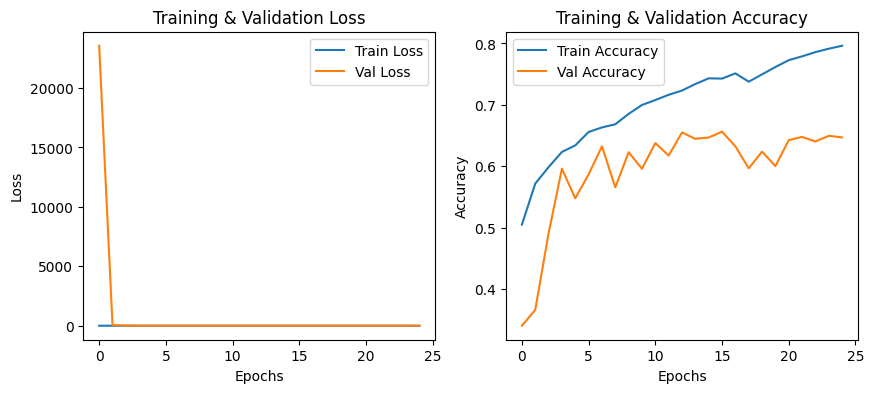

In [22]:
# Plot accuracy and loss data
def plot_training_history(history):
    plt.figure(figsize=(10, 4))
    
    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training & Validation Loss')

    # Accuracy Plot (if applicable)
    if 'accuracy' in history.history:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Val Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title('Training & Validation Accuracy')

    plt.show()

# Display training history
plot_training_history(history)

## Predict Full Area
With the model trained it can now be used to predict land use classes for a new aerial image. The image will be split into patches of the same size as the training patches, but can be set to have a different step for more or less overlap. More overlap produces (diminishingly) smoother results at the cost of much more memory during the prediction phase. Once averaged back into one image however, the resulting output should be the same size. 

In [23]:
# PATCHIFY IMAGE TO PREDICT
patch_step_pred = patch_size // 4
full_image_reshaped = reshape_as_image(full_image)
if optional_shapes: print("Full Image shape:", full_image_reshaped.shape)  

# Turn full image into patches to be predicted 
patches_full = patchify(full_image_reshaped, (patch_size, patch_size, 3), step=patch_step_pred)
patches_full_x, patches_full_y = patches_full.shape[0:2]

# Turn 2D array of patches into one list of patches i.e. (num_patches, patch_size, patch_size, bands)
patches_full_reshaped = patches_full.reshape(-1, patch_size, patch_size, 3)
if optional_shapes: print("Reshaped for Model shape:", patches_full_reshaped.shape)  

Full Image shape: (2892, 4336, 3)
Reshaped for Model shape: (11484, 128, 128, 3)


#### Predict patches in batches
To reduce likelihood of crashing due to an out of memory exception, high resolution images should be predicted in batches of patches, instead of all at once.

In [24]:
# PREDICT IMAGE PATCHES
# Predict the full image in batches to avoid memory constraints
batch_size = 4096
num_patches = patches_full_reshaped.shape[0]
predictions_list = []

# Batch predictions
for start in range(0, num_patches, batch_size):
    end = min(start + batch_size, num_patches)
    batch_patches = patches_full_reshaped[start:end]
    preds = model.predict(batch_patches)
    predictions_list.append(preds)

# Concatenate predictions
predictions = np.concatenate(predictions_list, axis=0)

# Reshape back to original
predictions = predictions.reshape(patches_full.shape[0], patches_full.shape[1], patch_size, patch_size, -1)

# Get predicted classes
predicted_classes = np.argmax(predictions, axis=-1)

128/128 ━━━━━━━━━━━━━━━━━━━━ 457s 4s/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 457s 4s/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 369s 4s/step


#### ***Optional**: Free Up Some Memory*
If the resulting image is high resolution and has many overlapping patches, stitching them back together and displaying them will require significant memory. Purging unnecessary intermediate data can free up resources for this.

In [25]:
# OPTIONAL EXTRA GARBAGE COLLECTION 
# For memory management
if extra_garbage_collection:
    import gc
    del predictions, patches_full_reshaped
    gc.collect()

#### Reassemble the Image from Predicted Patches
Put the prediction patches into one image. To deal with the overlap, and average blend is taken. A guassian blend was attempted but created worse results given the square grid nature of the roadway network being predicted in Toronto.

In [26]:
# REASSEMBLE IMAGE
# Initialize accumulation and weight matrices
full_prediction = np.zeros((patches_full_x * patch_step_pred + patch_size, 
                            patches_full_y * patch_step_pred + patch_size), dtype=np.float32)
weight_matrix = np.zeros_like(full_prediction, dtype=np.float32)

# Blend patches (average blending)
for i in range(patches_full_x):
    for j in range(patches_full_y):
        x_start = i * patch_step_pred
        x_end = x_start + patch_size
        y_start = j * patch_step_pred
        y_end = y_start + patch_size
        
        full_prediction[x_start:x_end, y_start:y_end] += predicted_classes[i, j]
        weight_matrix[x_start:x_end, y_start:y_end] += 1  # Track contributions

# Normalize by the number of times each pixel was predicted
warnings.filterwarnings('ignore')
full_prediction = (full_prediction / weight_matrix).astype(np.float32)
full_prediction = full_prediction.astype(np.uint8)

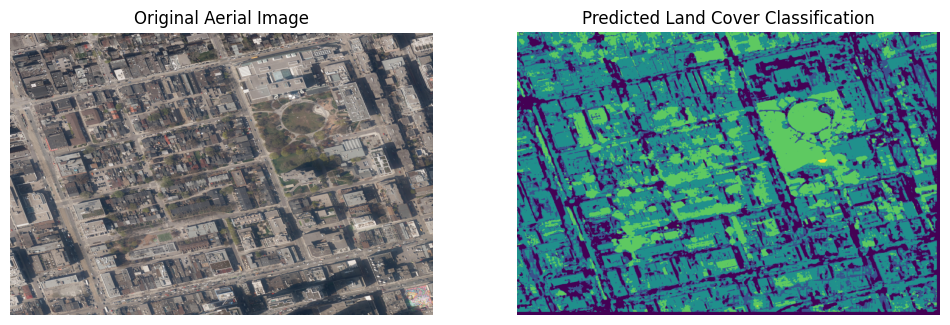

Input Aerials: 8 
Dim Aerials: (3, 512, 512) 
Patch Size, Step: (128, 32) 
Prediction Size: (3, 2892, 4336)


In [27]:
# DISPLAY RESULTS
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(full_image_reshaped)
ax[0].set_title("Original Aerial Image")
ax[0].set_axis_off()

ax[1].imshow(full_prediction) 
ax[1].set_title("Predicted Land Cover Classification")
ax[1].set_axis_off()
plt.show()

print(f"Input Aerials: {len(aerials)} \nDim Aerials: {aerials[0].shape} \nPatch Size, Step: {(patch_size, patch_step)} \nPrediction Size: {full_image.shape}")

## Export Result
Used to export the resulting prediction. The output classes are scaled to be spread between 0 and 255 so that they are immediately interpretable. In QGIS or other software, either the new values can be colour cast, or the output can be exported with its original classes (0-3) but will look black without colour assignment elsewhere.

In [28]:
model_name="_512_4layer_improved"
# Rescale predictions for visualization/export
scaled_prediction = full_prediction.astype(np.float32) #* (255.0 / num_classes)
scaled_prediction = np.clip(scaled_prediction, 0, 255).astype(np.uint8)

# Use original metadata
metadata.update({
    "dtype": "uint8",  # Match predicted dtype
    "count": 1,        # Single band output
})

# Save the prediction as a GeoTIFF
output_path = f"output/{len(aerials)}aerials_{aerials[0].shape[1]}in_res_{full_image.shape[1]}out_res_{patch_size}patch_{patch_step}step_{patch_step_pred}pred_step{model_name}.tif"
with rasterio.open(output_path, "w", **metadata) as dst:
    dst.write(scaled_prediction, 1)
print(f"Prediction saved to {output_path}")

Prediction saved to output/8aerials_512in_res_2892out_res_128patch_32step_32pred_step_512_4layer_improved.tif
